<a href="https://colab.research.google.com/github/duongtrung/Pytorch-tutorials/blob/main/12_pytorch_detectron2_object_detection_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brief introduction

official Git: [detectron2](https://github.com/facebookresearch/detectron2)

Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. It is the successor of Detectron and maskrcnn-benchmark. It supports a number of computer vision research projects and production applications in Facebook.

For MacOS and Unix users: conda install -c conda-forge detectron2

<img src="resources/Detectron2-Logo-Horz.png" width="500">

## For Windows users

By the time of this tutorial (**09.2022**) the Detectron2 does not officially support Windows OS.
It is a git tricky to install detectron2

For windows user, read this blog
https://medium.com/@yogeshkumarpilli/how-to-install-detectron2-on-windows-10-or-11-2021-aug-with-the-latest-build-v0-5-c7333909676f

However, the blog's content might be outdated.
Note from my installation

- Microsoft Visual C++ 14.0 or greater is required: https://visualstudio.microsoft.com/visual-cpp-build-tools/
Do not install Visual Studio 2022. Try either 2017 or 2019 version. I tried Visual Studio 2019 version 16.11.19. https://learn.microsoft.com/en-us/visualstudio/releases/2019/release-notes
- I have a RTX 3080 graphic card. I install CUDA Toolkits 11.3.
- If you get nvcc.exe' failed with exit code 1, do the following steps:
    - Edit PATH to where nvcc.exe (CUDA 11.3) is. For example, I copy to C:\CUDA\v11.3\bin
    - Open the detectron2\layers\csrc\nms_rotated\nms_rotated_cuda.cu file, and comment the two ifdef statements. See https://github.com/facebookresearch/detectron2/issues/1601

In [2]:
# import some common detectron2 utilities
import torch, detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo

from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os, json, cv2, random

In [3]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.12 ; cuda:  1.12.1
detectron2: 0.6


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


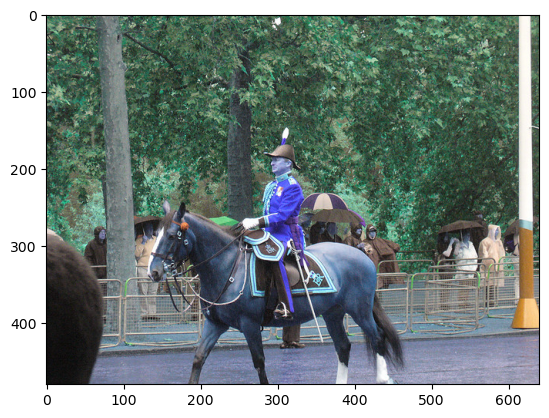

In [7]:
im = cv2.imread("resources/000000439715.jpg")
plt.imshow(im)
plt.show()

### We are using the pre-trained Detectron2 model

In [23]:
# obtain detectron2's default config
cfg = get_cfg()
# load the pre trained model from Detectron2 model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# set confidence threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
# load model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# create the predictor for pose estimation using the config
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

C:\Users\Lena\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\git-from-other\detectron2\detectron2\structures\keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


In [24]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[253.6289, 166.8560, 337.8578, 410.7047],
        [113.9893, 267.3926, 150.8951, 397.5752],
        [ 49.9474, 274.8307,  80.3443, 347.1417],
        [386.3576, 272.1286, 412.8906, 302.1223],
        [561.4427, 271.2316, 597.4076, 380.3336],
        [  1.7800, 281.9354,  76.7585, 478.0876],
        [522.6176, 280.9456, 562.6266, 383.9212],
        [404.0411, 273.3605, 461.3893, 347.6447],
        [353.9452, 269.3995, 385.4016, 298.6598],
        [341.6042, 268.6257, 363.2255, 299.0627],
        [593.4132, 268.4602, 614.2230, 314.5589],
        [509.0094, 286.8081, 534.0611, 338.4213]], device='cuda:0'))


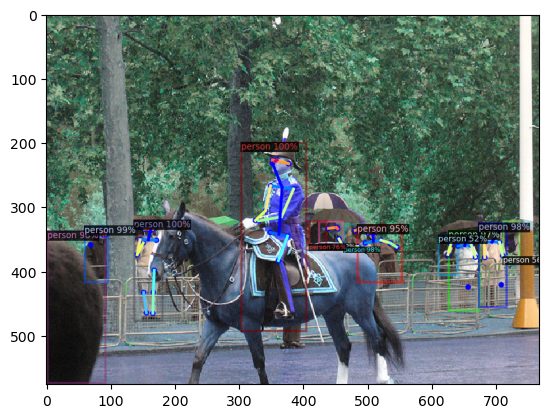

In [29]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

out = out.get_image()[:, :, ::-1]

plt.imshow(out)
plt.show()

### LSTM model definition

In [19]:
import pytorch_lightning as pl

# We have 6 output action classes.
TOT_ACTION_CLASSES = 6

#lstm classifier definition
class ActionClassificationLSTM(pl.LightningModule):

    # initialise method
    def __init__(self, input_features, hidden_dim, learning_rate=0.001):
        super().__init__()
        # save hyperparameters
        self.save_hyperparameters()
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        # The linear layer that maps from hidden state space to classes
        self.linear = nn.Linear(hidden_dim, TOT_ACTION_CLASSES)

    def forward(self, x):
        # invoke lstm layer
        lstm_out, (ht, ct) = self.lstm(x)
        # invoke linear layer
        return self.linear(ht[-1])


def training_step(self, batch, batch_idx):
    # get data and labels from batch
    x, y = batch
    # reduce dimension
    y = torch.squeeze(y)
    # convert to long
    y = y.long()
    # get prediction
    y_pred = self(x)
    # calculate loss
    loss = F.cross_entropy(y_pred, y)
    # get probability score using softmax
    prob = F.softmax(y_pred, dim=1)
    # get the index of the max probability
    pred = prob.data.max(dim=1)[1]
    # calculate accuracy
    acc = torchmetrics.functional.accuracy(pred, y)
    dic = {
        'batch_train_loss': loss,
        'batch_train_acc': acc
    }
    # log the metrics for pytorch lightning progress bar or any other operations
    self.log('batch_train_loss', loss, prog_bar=True)
    self.log('batch_train_acc', acc, prog_bar=True)
    #return loss and dict
    return {'loss': loss, 'result': dic}

def training_epoch_end(self, training_step_outputs):
    # calculate average training loss end of the epoch
    avg_train_loss = torch.tensor([x['result']['batch_train_loss'] for x in training_step_outputs]).mean()
    # calculate average training accuracy end of the epoch
    avg_train_acc = torch.tensor([x['result']['batch_train_acc'] for x in training_step_outputs]).mean()
    # log the metrics for pytorch lightning progress bar and any further processing
    self.log('train_loss', avg_train_loss, prog_bar=True)
    self.log('train_acc', avg_train_acc, prog_bar=True)

def validation_step(self, batch, batch_idx):
    # get data and labels from batch
    x, y = batch
    # reduce dimension
    y = torch.squeeze(y)
    # convert to long
    y = y.long()
    # get prediction
    y_pred = self(x)
    # calculate loss
    loss = F.cross_entropy(y_pred, y)
    # get probability score using softmax
    prob = F.softmax(y_pred, dim=1)
    # get the index of the max probability
    pred = prob.data.max(dim=1)[1]
    # calculate accuracy
    acc = torchmetrics.functional.accuracy(pred, y)
    dic = {
        'batch_val_loss': loss,
        'batch_val_acc': acc
    }
    # log the metrics for pytorch lightning progress bar and any further processing
    self.log('batch_val_loss', loss, prog_bar=True)
    self.log('batch_val_acc', acc, prog_bar=True)
    #return dict
    return dic

def validation_epoch_end(self, validation_step_outputs):
    # calculate average validation loss end of the epoch
    avg_val_loss = torch.tensor([x['batch_val_loss']
                                for x in validation_step_outputs]).mean()
    # calculate average validation accuracy end of the epoch
    avg_val_acc = torch.tensor([x['batch_val_acc']
                               for x in validation_step_outputs]).mean()
    # log the metrics for pytorch lightning progress bar and any further processing
    self.log('val_loss', avg_val_loss, prog_bar=True)
    self.log('val_acc', avg_val_acc, prog_bar=True)

def configure_optimizers(self):
    # adam optimiser
    optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    # learning rate reducer scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-15, verbose=True)
    # scheduler reduces learning rate based on the value of val_loss metric
    return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "interval": "epoch", "frequency": 1, "monitor": "val_loss"}}


### Application